# EV Load Forecasting Model
### Dynamic Load Management System
**Student:** Ildar Mamin
**Institution:** Laurea University of Applied Sciences

---
**Objective:** To predict future energy demand for Electric Vehicle (EV) charging stations using historical session data and XGBoost regression.

### 1. Initialization of Analytical Environment

This section initializes the computational environment required for the data analysis and modeling pipeline. The following key libraries are utilized:

* **Pandas & NumPy:** For high-performance data manipulation and array operations.
* **XGBoost:** Selected as the regression algorithm due to its efficiency in handling tabular time-series data and non-linear relationships.
* **Scikit-Learn:** Used for performance evaluation metrics (Mean Absolute Error).
* **Joblib:** Employed for model serialization, allowing the trained artifacts to be deployed in external applications.

In [41]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
import joblib  # For saving the model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

plt.style.use('seaborn-v0_8-whitegrid')
print("Result: All libraries are loaded")

Result: All libraries are loaded


### 2. Data Acquisition and Preprocessing

The raw dataset consists of unstructured JSON logs representing individual EV charging sessions. To prepare this data for load forecasting, the following preprocessing steps are applied:

1.  **Data Ingestion:** The JSON structure is flattened into a tabular DataFrame format.
2.  **Temporal Parsing:** Timestamps for connection and disconnection events are converted to datetime objects.
3.  **Metric Derivation:** As the raw data provides total energy ($kWh$) but not real-time power curves, the **Average Power ($kW$)** is derived for each session using the formula:
    $$P_{avg} = \frac{E_{total}}{T_{duration}}$$
4.  **Data Quality Control:** Sessions with null values or anomalous power readings (exceeding physical charger limits of 22kW) are filtered out to ensure data integrity.

In [42]:
file_path = 'data.json'

print("Loading data...")
with open(file_path, 'r') as f:
    raw_data = json.load(f)

sessions_list = raw_data['_items']
df_sessions = pd.json_normalize(sessions_list)

time_cols = ['connectionTime', 'disconnectTime', 'doneChargingTime']
for col in time_cols:
    df_sessions[col] = pd.to_datetime(df_sessions[col], errors='coerce')

df_sessions = df_sessions.dropna(subset=['connectionTime', 'disconnectTime', 'kWhDelivered'])
df_sessions = df_sessions[df_sessions['kWhDelivered'] > 0]

df_sessions['charge_end'] = df_sessions['doneChargingTime'].fillna(df_sessions['disconnectTime'])
df_sessions['duration_hours'] = (df_sessions['charge_end'] - df_sessions['connectionTime']).dt.total_seconds() / 3600

df_sessions = df_sessions[df_sessions['duration_hours'] > 0.05]
df_sessions['avg_power_kw'] = df_sessions['kWhDelivered'] / df_sessions['duration_hours']

df_sessions['avg_power_kw'] = df_sessions['avg_power_kw'].clip(upper=22.0)

print(f"✅ Loaded {len(df_sessions)} valid real-world sessions.")
df_sessions[['connectionTime', 'kWhDelivered', 'avg_power_kw']].head()

Loading data...
✅ Loaded 6415 valid real-world sessions.


,connectionTime,kWhDelivered,avg_power_kw
0,2019-11-01 13:41:16,5.653,2.794672
1,2019-11-01 13:43:51,8.040,0.897155
2,2019-11-01 13:53:52,8.966,2.565175
3,2019-11-01 13:54:22,6.545,1.546570
4,2019-11-01 13:56:52,13.632,5.877269


### 3. Temporal Aggregation and Load Profile Construction

Forecasting require a continuous time-series rather than discrete transaction logs. This step transforms the event-based session data into a site-wide aggregate load profile.

**Methodology:**
* A continuous time index is generated with a **15-minute resolution**, aligning with standard smart meter intervals.
* An iterative "stacking" algorithm assigns the derived average power of each active session to the corresponding time intervals between `connectionTime` and `doneChargingTime`.
* **Output:** A univariate time series representing the total site load ($kW$) at every 15-minute step.

Constructing Site Load Profile (Time Series)... This may take a moment.
Processing session 0/6415...
Processing session 641/6415...
Processing session 1282/6415...
Processing session 1923/6415...
Processing session 2564/6415...
Processing session 3205/6415...
Processing session 3846/6415...
Processing session 4487/6415...
Processing session 5128/6415...
Processing session 5769/6415...
Processing session 6410/6415...
✅ Transformation Complete!
Created load profile with 14634 timestamps.


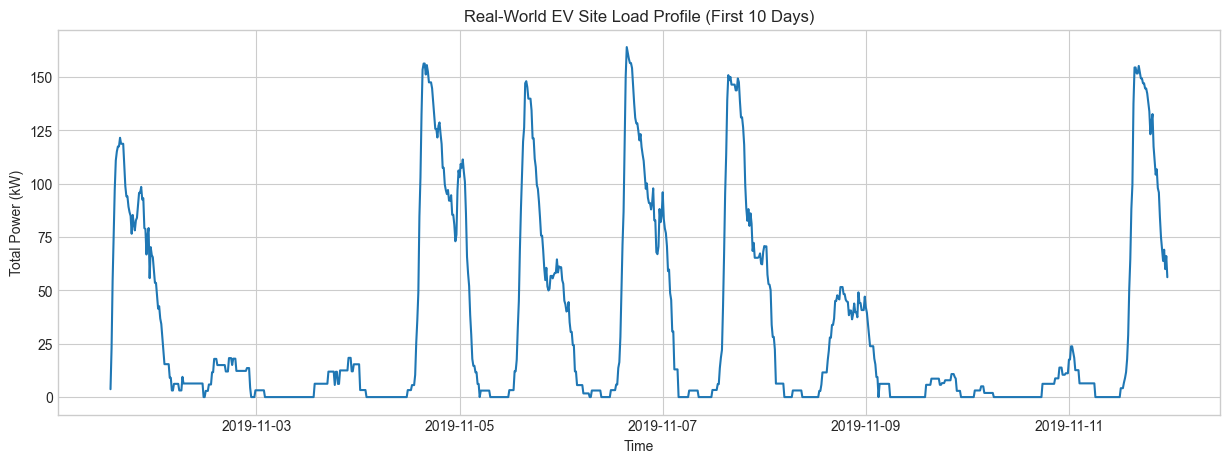

In [43]:
print("Constructing Site Load Profile (Time Series)... This may take a moment.")

start_date = df_sessions['connectionTime'].min().floor('15min')
end_date = df_sessions['disconnectTime'].max().ceil('15min')
time_index = pd.date_range(start=start_date, end=end_date, freq='15min')

df_load = pd.DataFrame(0.0, index=time_index, columns=['total_load_kw', 'active_sessions'])

count = 0
total = len(df_sessions)

for idx, row in df_sessions.iterrows():
    if count % (total // 10) == 0:
        print(f"Processing session {count}/{total}...")

    start = row['connectionTime'].floor('15min')
    end = row['charge_end'].ceil('15min')

    mask = (df_load.index >= start) & (df_load.index <= end)
    df_load.loc[mask, 'total_load_kw'] += row['avg_power_kw']
    df_load.loc[mask, 'active_sessions'] += 1

    count += 1

print("✅ Transformation Complete!")
print(f"Created load profile with {len(df_load)} timestamps.")

plt.figure(figsize=(15, 5))
plt.plot(df_load.index[:1000], df_load['total_load_kw'][:1000]) # Plot first ~10 days
plt.title("Real-World EV Site Load Profile (First 10 Days)")
plt.ylabel("Total Power (kW)")
plt.xlabel("Time")
plt.show()

### 4. Feature Engineering and Predictive Modeling

To capture the temporal dependencies and seasonality inherent in EV charging behavior, specific features are engineered from the historical data.

**Feature Extraction:**
* **Autoregressive Lag Features:** `lag_24h` (Daily Seasonality) and `lag_1h` (Short-term Dependency) are generated to allow the model to learn from past states.
* **Rolling Statistics:** A 24-hour rolling mean is calculated to capture the underlying daily trend, smoothing out high-frequency noise.

**Algorithm and Training:**
An **XGBoost Regressor** is trained on the engineered features. The dataset is split into training (80%) and testing (20%) sets to evaluate generalization performance. The model performance is quantified using the **Mean Absolute Error (MAE)**.

In [44]:
df_ml = df_load.copy()
df_ml['hour'] = df_ml.index.hour
df_ml['day_of_week'] = df_ml.index.dayofweek
df_ml['month'] = df_ml.index.month

df_ml['lag_24h'] = df_ml['total_load_kw'].shift(96)
df_ml['lag_1h'] = df_ml['total_load_kw'].shift(4)

df_ml['rolling_mean_24h'] = df_ml['total_load_kw'].rolling(window=96).mean()

df_ml = df_ml.dropna()

split_point = int(len(df_ml) * 0.8)
train = df_ml.iloc[:split_point]
test = df_ml.iloc[split_point:]

features = ['hour', 'day_of_week', 'lag_24h', 'lag_1h', 'rolling_mean_24h']
target = 'total_load_kw'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

print("Training XGBoost Model on Real Data...")
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    early_stopping_rounds=50
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

print("✅ Model Trained successfully.")

preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"Mean Absolute Error: {mae:.2f} kW")

joblib.dump(model, 'real_data_model.pkl')
df_ml.to_csv('processed_load_profile.csv')
print("💾 Model and Data saved! Ready for Streamlit.")

Training XGBoost Model on Real Data...
✅ Model Trained successfully.
Mean Absolute Error: 5.83 kW
💾 Model and Data saved! Ready for Streamlit.


### 5. Artifact Serialization for Deployment

To facilitate the integration of the forecasting model into a live dashboard (Dynamic Load Management System), the trained model and processed data must be persisted.

* **Model Serialization:** The trained XGBoost estimator is serialized to a `.pkl` file using `joblib`.
* **Data Persistence:** The processed time-series dataframe is exported to CSV. This allows the production system to access historical lags required for generating future predictions.

In [45]:
import joblib

print("Saving model and data for the Dashboard...")

joblib.dump(model, 'real_data_model.pkl')

df_ml.to_csv('processed_load_profile.csv')

print("✅ Success! Files created:")
print("   - real_data_model.pkl (The Brain)")
print("   - processed_load_profile.csv (The Memory)")
print("You are now ready to build the Streamlit App.")

Saving model and data for the Dashboard...
✅ Success! Files created:
   - real_data_model.pkl (The Brain)
   - processed_load_profile.csv (The Memory)
You are now ready to build the Streamlit App.


### 6. Forecasting Simulation and Inference Validation

This section simulates the operational inference pipeline. A forecast horizon of 24 hours (96 intervals) is generated following the last observed data point.

The simulation tests the model's ability to construct a future load curve using the engineered lag features. This step serves as a validation of the end-to-end forecasting logic prior to deployment.

Simulating a 24-hour forecast...
Latest data point is from: 2020-04-01 23:45:00


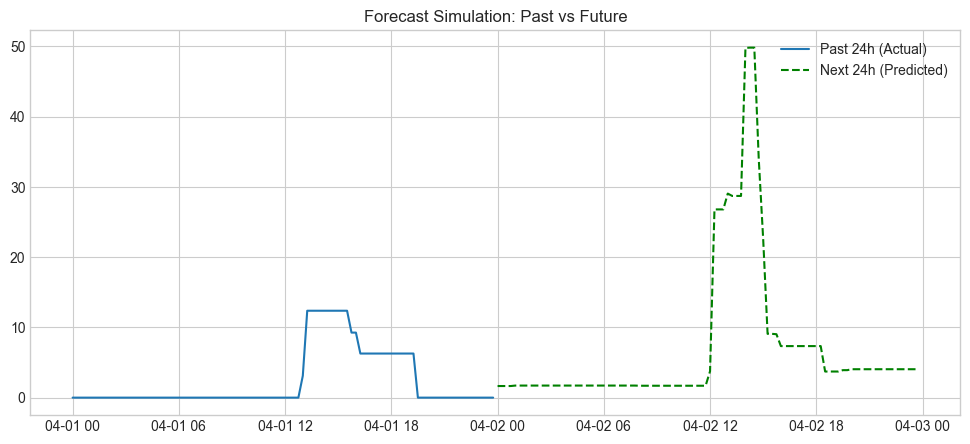

In [46]:
print("Simulating a 24-hour forecast...")

last_timestamp = df_ml.index[-1]
print(f"Latest data point is from: {last_timestamp}")

future_index = pd.date_range(
    start=last_timestamp + pd.Timedelta(minutes=15),
    periods=96,  # 24 hours * 4 quarters
    freq='15min'
)

df_future = pd.DataFrame(index=future_index)
df_future['hour'] = df_future.index.hour
df_future['day_of_week'] = df_future.index.dayofweek
df_future['month'] = df_future.index.month

last_24h_data = df_ml['total_load_kw'].iloc[-96:].values
df_future['lag_24h'] = last_24h_data
df_future['lag_1h'] = np.roll(last_24h_data, -4) # Approximate for test
df_future['rolling_mean_24h'] = df_ml['rolling_mean_24h'].iloc[-96:].values # Approximate

# Prediction
future_preds = model.predict(df_future[['hour', 'day_of_week', 'lag_24h', 'lag_1h', 'rolling_mean_24h']])

# Plot the Forecast
plt.figure(figsize=(12, 5))
plt.plot(df_ml.index[-96:], df_ml['total_load_kw'].iloc[-96:], label="Past 24h (Actual)")
plt.plot(future_index, future_preds, label="Next 24h (Predicted)", color='green', linestyle='--')
plt.title("Forecast Simulation: Past vs Future")
plt.legend()
plt.show()